In [6]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os

In [7]:
df = pd.read_csv("../enhanced_anesthesia_dataset_v4.csv")

In [8]:
df['General_Response'] = df['General_Response'].replace({
    'Adverse: Arrhythmia': 'Adverse',
    'Adverse: Hypotension': 'Adverse',
    'Adverse: Nausea/Vomiting': 'Adverse',
    'Adverse: Respiratory': 'Adverse'
})

In [9]:
features = [
    'Age', 'Gender', 'Height_cm', 'Weight_kg', 'BMI', 'IBW', 'ABW', 'Diet',
    'OrganFunction', 'KidneyFunction', 'CardiovascularHistory',
    'Diabetes', 'CurrentMedications', 'ProcedureType', 'ASA_Class',
    'ALDH2_Genotype', 'CYP2D6_Type', 'CYP2C9_Type', 'CYP2B6_Type', 'CYP3A4_Type',
    'UGT1A1_Variant', 'RYR1_Variant', 'SCN9A_Variant', 'F5_Variant',
    'GABRA2_Variant', 'OPRM1_Variant', 'General_AnesthesiaType', 'General_Dosage'
]

target = 'General_Response'



In [10]:
df.dropna(subset=features + [target], inplace=True)

In [11]:
max_size = df[target].value_counts().max()
balanced_frames = []

for cls in df[target].unique():
    class_df = df[df[target] == cls]
    upsampled = resample(class_df, replace=True, n_samples=max_size, random_state=42)
    balanced_frames.append(upsampled)

balanced_df = pd.concat(balanced_frames).sample(frac=1, random_state=42)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    balanced_df[features], balanced_df[target],
    test_size=0.2, random_state=42, stratify=balanced_df[target]
)

In [13]:
cat_features = [i for i, col in enumerate(X_train.columns) if df[col].dtype == 'object']

In [14]:
model = CatBoostClassifier(
    loss_function='MultiClass',
    random_state=42,
    verbose=100
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.11747
0:	learn: 1.0936841	test: 1.0938194	best: 1.0938194 (0)	total: 250ms	remaining: 4m 9s
100:	learn: 1.0387695	test: 1.0505398	best: 1.0505398 (100)	total: 11.9s	remaining: 1m 46s
200:	learn: 0.9944842	test: 1.0176400	best: 1.0176400 (200)	total: 23.4s	remaining: 1m 33s
300:	learn: 0.9557945	test: 0.9892456	best: 0.9892456 (300)	total: 34.8s	remaining: 1m 20s
400:	learn: 0.9207431	test: 0.9626962	best: 0.9626962 (400)	total: 46.8s	remaining: 1m 9s
500:	learn: 0.8897823	test: 0.9395264	best: 0.9395264 (500)	total: 58.6s	remaining: 58.4s
600:	learn: 0.8608340	test: 0.9171928	best: 0.9171928 (600)	total: 1m 10s	remaining: 46.6s
700:	learn: 0.8324406	test: 0.8959766	best: 0.8959766 (700)	total: 1m 21s	remaining: 34.8s
800:	learn: 0.8084003	test: 0.8769721	best: 0.8769721 (800)	total: 1m 33s	remaining: 23.2s
900:	learn: 0.7847761	test: 0.8593560	best: 0.8593560 (900)	total: 1m 45s	remaining: 11.5s
999:	learn: 0.7617956	test: 0.8420830	best: 0.8420830 (999)	total: 1

In [15]:
y_pred = model.predict(X_test)

print("\n📊 Classification Report (General_Response):")
print(classification_report(y_test, y_pred))


📊 Classification Report (General_Response):
              precision    recall  f1-score   support

     Adverse       0.72      0.78      0.75      5634
   Effective       0.63      0.59      0.61      5634
 Ineffective       0.67      0.65      0.66      5634

    accuracy                           0.67     16902
   macro avg       0.67      0.67      0.67     16902
weighted avg       0.67      0.67      0.67     16902



In [16]:
probas = model.predict_proba(X_test)
labels = model.classes_

# Custom threshold logic
thresholds = {
    'Adverse': 0.60,
    'Ineffective': 0.50,
    'Effective': 0.50
}

final_preds = []
for row in probas:
    top_idx = np.argmax(row)
    top_class = labels[top_idx]
    top_prob = row[top_idx]

    # If top class meets its threshold, use it
    if top_prob >= thresholds.get(top_class, 0.5):
        final_preds.append(top_class)
    else:
        # Try second-best class
        sorted_indices = np.argsort(row)
        second_idx = sorted_indices[-2]
        second_class = labels[second_idx]
        second_prob = row[second_idx]

        if second_prob >= thresholds.get(second_class, 0.5):
            final_preds.append(second_class)
        else:
            final_preds.append("Uncertain")  # Neither class is confident enough
print("\n📊 Classification Report (Smart Fallback):")
print(classification_report(y_test, final_preds))


📊 Classification Report (Smart Fallback):
              precision    recall  f1-score   support

     Adverse       0.96      0.28      0.43      5634
   Effective       0.84      0.21      0.34      5634
 Ineffective       0.85      0.29      0.43      5634
   Uncertain       0.00      0.00      0.00         0

    accuracy                           0.26     16902
   macro avg       0.66      0.20      0.30     16902
weighted avg       0.88      0.26      0.40     16902



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


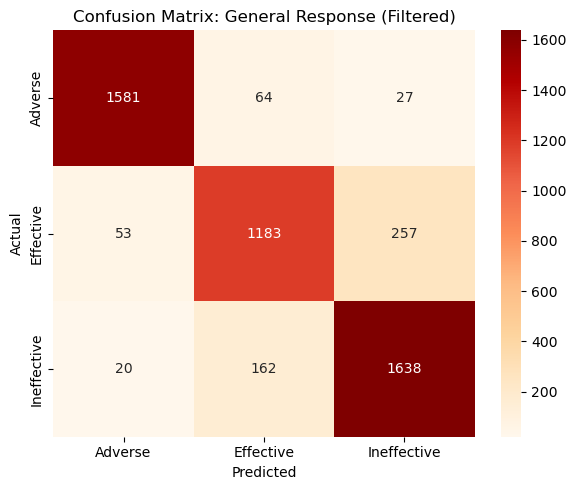

In [17]:
# Confusion Matrix (excluding "Uncertain")
filtered_preds = [p for p in final_preds if p != "Uncertain"]
filtered_true = [y for y, p in zip(y_test, final_preds) if p != "Uncertain"]

conf_matrix = confusion_matrix(filtered_true, filtered_preds, labels=labels)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='OrRd',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix: General Response (Filtered)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict class labels
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

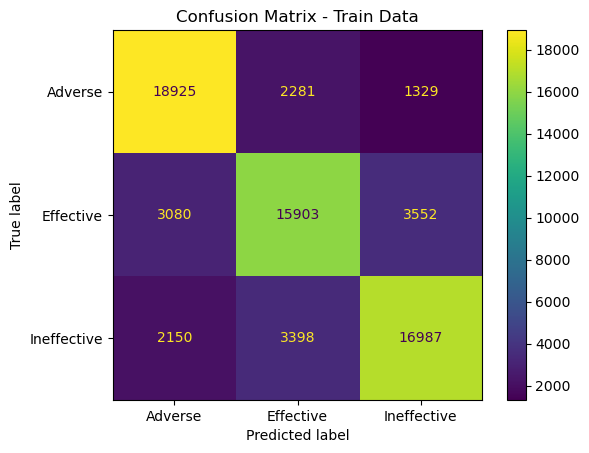

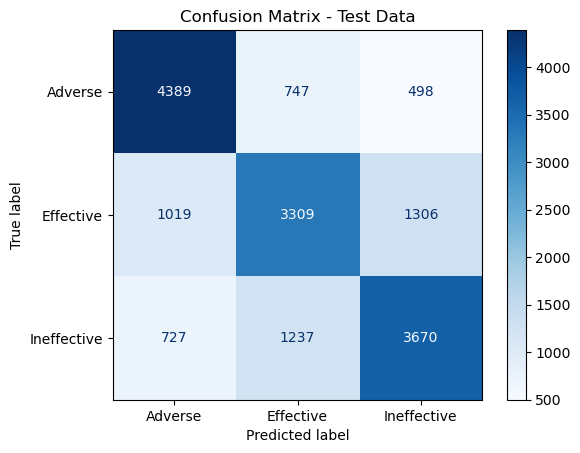

In [19]:
import matplotlib.pyplot as plt

# --- Train Confusion Matrix ---
train_cm = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=model.classes_)
disp_train.plot()
plt.title('Confusion Matrix - Train Data')
plt.grid(False)
plt.show()

# --- Test Confusion Matrix ---
test_cm = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=model.classes_)
disp_test.plot(cmap='Blues')
plt.title('Confusion Matrix - Test Data')
plt.grid(False)
plt.show()

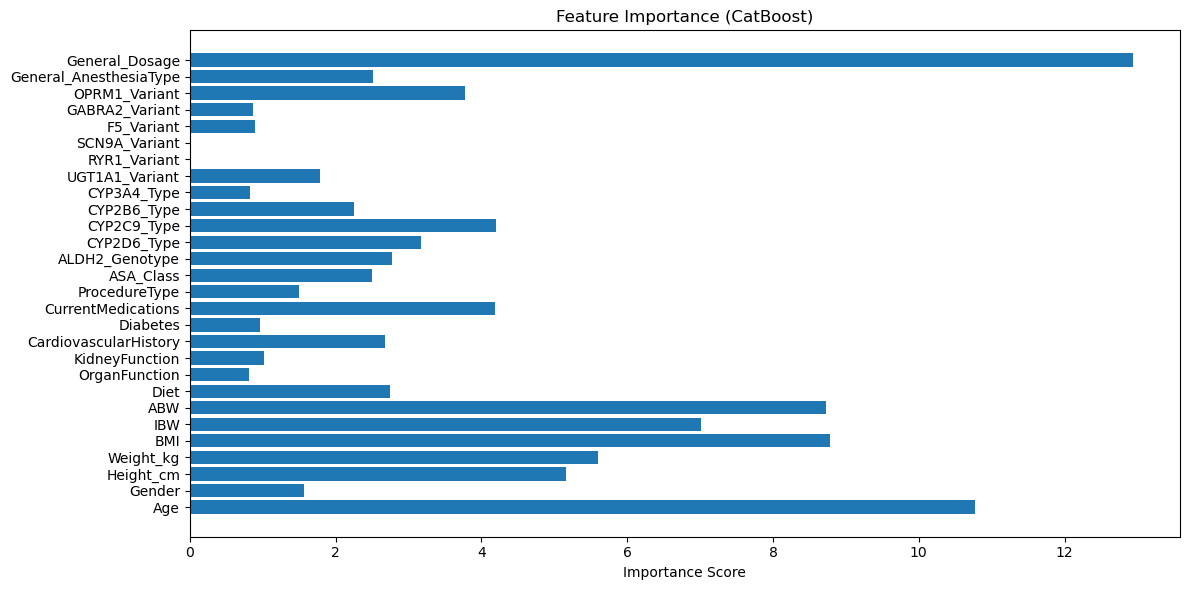

In [20]:
import matplotlib.pyplot as plt

feature_importances = model.get_feature_importance()
feature_names = X_train.columns

# Plot
plt.figure(figsize=(12, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Importance Score')
plt.title('Feature Importance (CatBoost)')
plt.tight_layout()
plt.show()


In [21]:
os.makedirs("saved_model", exist_ok=True)
model.save_model("saved_model/general_response_confidence_model.cbm")
joblib.dump({
    "features": features,
    "cat_features": cat_features,
    "target": target,
    "thresholds": thresholds
}, "saved_model/general_response_metadata_confidence.pkl")

print("\n✅ Model and metadata saved to 'saved_model/'")


✅ Model and metadata saved to 'saved_model/'
